# Titanic Survival Data Analysis
___

## Question: What factors made people more likely to survive?
___

### Load and Clean the Dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import math

#sns.set_style('whitegrid')
%matplotlib inline

In [2]:
titanic = pd.read_csv("titanic_data.csv")

print(titanic.info())
print("----------------------------")
print(titanic.describe())
# The Cabin column has so many missing values, so we can just ignore it.
titanic.drop('Cabin',axis=1,inplace=True)
titanic.drop('PassengerId',axis=1,inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
----------------------------
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000 

/Users/wislish/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


___
### Dealing with the missing values. `Three variables have missing values.`


YES    791
NO     100
Name: Is_Adult, dtype: int64


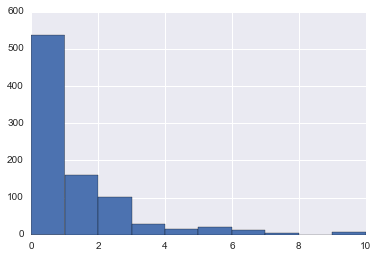

In [3]:
####################################################################
titanic.Age = titanic.Age.fillna(titanic.Age.median())
# Create a new column 'Is_Adult' to represent if the passenger is an adult
titanic.loc[titanic['Age'] >16, 'Is_Adult'] = 'YES'
titanic.loc[titanic['Age'] <=16, 'Is_Adult'] = 'NO'

print(titanic.Is_Adult.value_counts())

embarked_mode = titanic['Embarked'].mode().values
# print (embarked_mode)
titanic.Embarked = titanic["Embarked"].fillna(embarked_mode[0])

# Create a new column 'famSize' to represent the total number of family members.
titanic['famSize'] = titanic.SibSp + titanic.Parch
titanic['famSize'].hist()
# Bigger than 3 represents a big family
titanic.loc[titanic['famSize'] >=3, 'Is_Big_Family'] = 'YES'
titanic.loc[titanic['famSize'] <3, 'Is_Big_Family'] = 'NO'

In [4]:
titanic.info()
print("-----------------------------")
titanic.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Ticket           891 non-null object
Fare             891 non-null float64
Embarked         891 non-null object
Is_Adult         891 non-null object
famSize          891 non-null int64
Is_Big_Family    891 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB
-----------------------------


,Survived,Pclass,Age,SibSp,Parch,Fare,famSize
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208,0.904602
std,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429,1.613459
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,10.000000


___

### Answer the Question.
**1. Simple Methods**

This method calculates the rate of survival by grouping the whole dataset into 4 different subsets and getting the mean survival rate.

According to the calculation, we find that the '`Sex`' feature can tell whether passengers were dead or alive most effectively.

0.62962962963


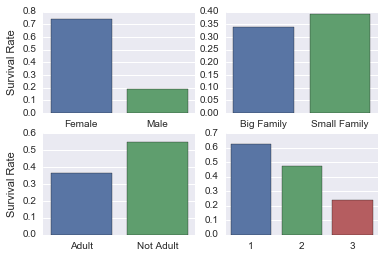

In [5]:
sex_survived = titanic.groupby('Sex').mean()['Survived']
family_survived = titanic.groupby('Is_Big_Family').mean()['Survived']
age_survived = titanic.groupby('Is_Adult').mean()['Survived']
pclass_survived = titanic.groupby('Pclass').mean()['Survived']

print (pclass_survived[1])

plt.subplot(221)
sns.barplot(x=['Female','Male'], y=[sex_survived['female'],sex_survived['male']])
plt.ylabel('Survival Rate')
plt.subplot(222)
sns.barplot(x=['Big Family','Small Family'], y=[family_survived['YES'],family_survived['NO']])
plt.subplot(223)
sns.barplot(x=['Adult','Not Adult'], y=[age_survived['YES'],age_survived['NO']])
plt.ylabel('Survival Rate')
plt.subplot(224)
sns.barplot(x=['1','2','3'], y=[pclass_survived[1],pclass_survived[2], pclass_survived[3]])



___
**2. Pearson Correlation** & **Pearson's Chi-square test**

In [6]:
from scipy.stats import pearsonr

# Convert the categorical variable into numeric
pear_titanic = titanic.copy()
pear_titanic.drop(['Name','Ticket'], axis = 1, inplace = True)
pear_titanic.info()
pear_titanic.loc[titanic['Sex'] == 'male','Sex'] = 1
pear_titanic.loc[titanic['Sex'] == 'female','Sex'] = 0

pear_titanic.loc[titanic['Embarked'] == 'C','Embarked'] = 0
pear_titanic.loc[titanic['Embarked'] == 'Q','Embarked'] = 1
pear_titanic.loc[titanic['Embarked'] == 'S','Embarked'] = 2

pear_titanic.loc[titanic['Is_Adult'] == 'YES','Is_Adult'] = 1
pear_titanic.loc[titanic['Is_Adult'] == 'NO','Is_Adult'] = 0

pear_titanic.loc[titanic['Is_Big_Family'] == 'YES','Is_Big_Family'] = 1
pear_titanic.loc[titanic['Is_Big_Family'] == 'NO','Is_Big_Family'] = 0

pear_dic = {}
for col in pear_titanic.columns:
    pear_dic[col] = pearsonr(pear_titanic[col], pear_titanic.Survived)

print ('--------------------------------')
# print the Pearson value in descending order
for var, pearson in sorted(pear_dic.items(), key=lambda t: abs(t[1][0]), reverse=True):
    print("{0} Pearson Correlation and P value {1}".format(var,pearson))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Embarked         891 non-null object
Is_Adult         891 non-null object
famSize          891 non-null int64
Is_Big_Family    891 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.6+ KB
--------------------------------
Survived Pearson Correlation and P value (1.0, 0.0)
Sex Pearson Correlation and P value (-0.54335138065775368, 1.4060661308810755e-69)
Pclass Pearson Correlation and P value (-0.33848103596101536, 2.5370473879804202e-25)
Fare Pearson Correlation and P value (0.25730652238496243, 6.1201893419218733e-15)
Embarked Pearson Correlation and P value (-0.16767531386772036, 4.8110926945859104e-07)
Is_

____

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X, y = pear_titanic.iloc[:,1:len(pear_titanic.columns)],pear_titanic.iloc[:,0]
chi2Titan = SelectKBest(chi2, k=5).fit(X, y)
print (-np.log10(chi2Titan.pvalues_[1]))
i = 0
for col in pear_titanic.columns:    
    if col != 'Survived':
        print ("Pearson Chi-square test for {0} is {1}".format(col,-np.log10(chi2Titan.pvalues_[i])))
        i = i+1

21.216250861
Pearson Chi-square test for Pclass is 7.5600698703429545
Pearson Chi-square test for Sex is 21.21625086104928
Pearson Chi-square test for Age is 5.484983905379359
Pearson Chi-square test for SibSp is 0.9661975676311659
Pearson Chi-square test for Parch is 2.8283593144673884
Pearson Chi-square test for Fare is inf
Pearson Chi-square test for Embarked is 2.853101721089229
Pearson Chi-square test for Is_Adult is 0.6489285049201166
Pearson Chi-square test for famSize is 0.39821627062498366
Pearson Chi-square test for Is_Big_Family is 0.40120148638043496


In [9]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Ticket           891 non-null object
Fare             891 non-null float64
Embarked         891 non-null object
Is_Adult         891 non-null object
famSize          891 non-null int64
Is_Big_Family    891 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB
